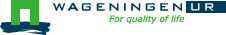



# WOFOST POTATO simulations for India experiment design
This Jupyter notebook will run WOFOST POTATO model to simulate water balance over 90 days period.  
The objectives are:  
1. Provide reference information about the effectiveness of the treatment.  
2. Verifying weather or not the treatment will cause earlier crop failure.  
3. Identify potential parameters to calibrate, also to suggest key plant traits to measure in the field. 

# 1. Importing the relevant modules

First the required modules need to be imported. For this *getting started* we only need PCSE, pandas and matplotlib

In [62]:
# allow matplotlib to show graph without plt.show()
%matplotlib inline                         
import sys, os                              # library to interact with system
import pandas as pd                         # data manipulation
import pcse                                 # Python Crop Simulation Environment
from plotnine import *                      # visulisation package that uses R sytle syntax
import matplotlib                           # import the classic python visualisation package
matplotlib.style.use("ggplot")              # change the default theme to ggplot theme
import matplotlib.pyplot as plt             # import the classic python visualisation package and named plt
print("This notebook was built with:")      # print information 
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)] 
PCSE version: 5.5.3


# Read parameter values

In [63]:
# load two data import functions from the pcse.fileinput class
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader
# load the available crop list  
cropd = YAMLCropDataProvider(fpath='../Data/')  
# load the soil information
soild = CABOFileReader('../Data/ec3 sandyloam.soil')
# load one data import function from the pcse.util class
from pcse.util import WOFOST72SiteDataProvider
# define the site initial condiations 
# WAV is the initial soil water content = 0; CO2 is the level of CO2 in the atmosphere = 360 ppm
sited = WOFOST72SiteDataProvider(WAV=0, CO2=360)
print(sited)
# help(WOFOST72SiteDataProvider)


YAMLCropDataProvider - Failed to load cache file: [WinError 2] The system cannot find the file specified: 'potato'
Unknown parameter values provided to WOFOSTSiteDataProvider: {'CO2': 360}
{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 0.0, 'SMLIM': 0.4}


In [64]:
# load one data import function from the pcse.base class
from pcse.base import ParameterProvider
# combine all the input parameters 
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

In [65]:
# load the weather data import function from the pcse.fileinput class
from pcse.fileinput import ExcelWeatherDataProvider
# read the weather data 
wdp = ExcelWeatherDataProvider('../Data/india2021-22.xlsx')
print(wdp)

Weather data provided by: ExcelWeatherDataProvider
--------Description---------
Weather data for:
Country: India
Station: NASA Power
Description: Simulated data downloaded from NASA POWER
Source: NASA Power
Contact: Jian
----Site characteristics----
Elevation:   -2.0
Latitude:  23.842
Longitude: 73.130
Data available for 2021-10-01 - 2022-03-31
Number of missing days: 0



<AxesSubplot:xlabel='DAY'>

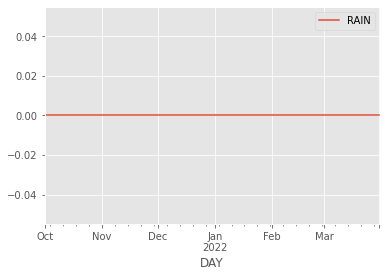

In [66]:
# Verify the weather data 
weather = pd.read_excel('../Data/india2021-22.xlsx', skiprows=10)
# Drop the 1st Row (unit row). In python, position number starts from 0. 
# therefore 1st row = 0 
weather.drop(axis=0, index = 0, inplace=True)
# Change column types to numeric 
weather[['IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOWDEPTH']] = weather[['IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOWDEPTH']].apply(pd.to_numeric)
# Change column type to datetime
weather.DAY = pd.to_datetime(weather.DAY)
# # verify if forced 0 success
# Set the datatime column as index - easy plotting
weather.set_index('DAY', inplace=True)
# Simple time series plotting to verify if rain = 0 all the time 
weather.plot(y = 'RAIN')

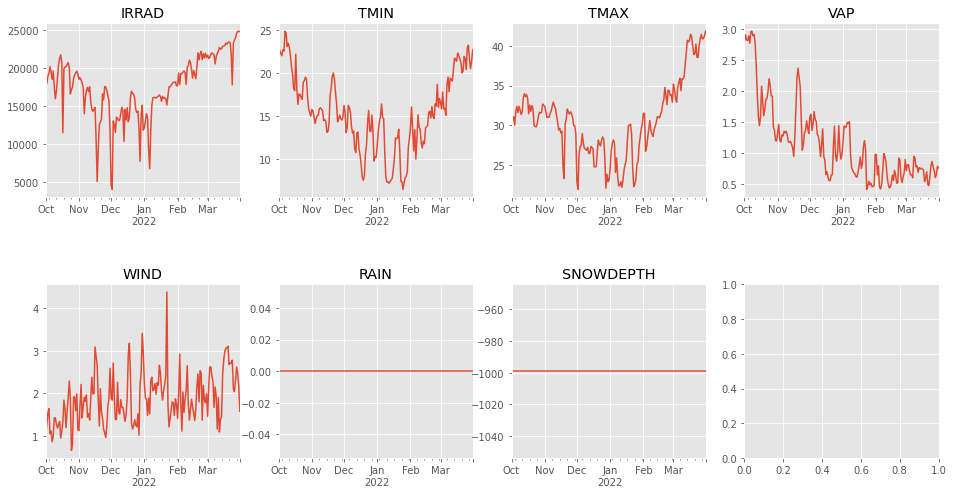

In [67]:
# Declare the column names for plotting
cols = ['IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOWDEPTH']
#https://engineeringfordatascience.com/posts/matplotlib_subplots/
# Create to variables fig and axes. 
# The fig defines the size of the plotting area
# The axes defines the subplot 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
# Define the horiztonal space in between subplot 
plt.subplots_adjust(hspace=0.5)
# Iterate through the cols and subplot to draw the data on each subplot 
for col, ax in zip(cols, axes.ravel()):    
    # subset each column from cols variable and plot the number on the subplot ax
    weather[[col]].plot(ax=ax)
    # change the title to upper case
    ax.set_title(col.upper())
    # remove the legend
    ax.get_legend().remove()
    # remove the x axis name 
    ax.set_xlabel("")

plt.show()

<AxesSubplot:xlabel='DAY'>

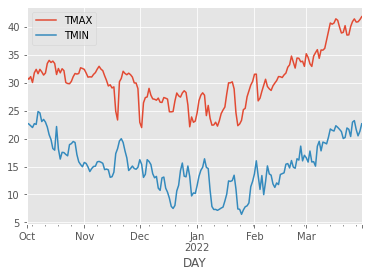

In [68]:
# Quick visualistion to see the comparison of TMAX and TMIN
weather[['TMAX', 'TMIN']].plot()

### Temperature is a bit high

### Run a potential potato model with india weather and dutch cultivar

In [69]:
# NO IRRIGATION AGRONOMANAGEMNT 
# Define a crop agronomic management agenda; 
# See the pcse_notebook [06](https://github.com/ajwdewit/pcse_notebooks/blob/master/06_advanced_agromanagement_with_PCSE.ipynb)
# for more information
import yaml
yaml_agro = """
- 2021-10-05:
    CropCalendar:
        crop_name: potato
        variety_name: Potato_704
        crop_start_date: 2021-10-10
        crop_start_type: sowing
        crop_end_date: 2022-01-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null       
    StateEvents: null
"""
# Load the agenda into memory
agromanagement_null = yaml.safe_load(yaml_agro)

In [70]:
# Load two WOFOST models from the model repos
# WOFOST72_WLP_FD - water limited potential yield model 
# WOFOST72_PP - potential yield model which means no limiting factors
from pcse.models import Wofost72_WLP_FD, Wofost72_PP
# Construct a potential yield model with no limiting factor
wofsim = Wofost72_PP(parameters, wdp, agromanagement_null)

In [71]:
# Run the potential yield model
wofsim.run_till_terminate()
# Retrieve the simulation results
PP_results = pd.DataFrame(wofsim.get_output())
# Change the day column to datetime type
PP_results.day = pd.to_datetime(PP_results.day)
# Set the day column as index and overwrite the copy in memory
PP_results.set_index("day", inplace=True)
# Show the column names in the dataframe
PP_results.columns

Index(['DVS', 'LAI', 'TAGP', 'TWSO', 'TWLV', 'TWST', 'TWRT', 'TRA', 'RD', 'SM',
       'WWLOW'],
      dtype='object')

Table 2. Description of the output of Potential Crop Production table window.
YEAR - year of the simulation time step  
DAY - day of year of the simulation time step (1-366)  
IDSEM  - number of days since emergence (d)   
DVS - development stage of crop (-)  
TSUM - thermal time since emergence (C d)  
WLV - dry weight of living leaves (kg ha-1)  
WST - dry weight of living stems (kg ha-1)  
WSO - dry weight of living storage organs (kg ha)  
**TAGP - total above ground production (dead and living plant organs) (kg ha-1)**  
TWRT - total dry weight of roots (dead and living) (kg ha-1)  
TWLV - total dry weight of leaves (dead and living) (kg ha-1)  
TWST - total dry weight of stems (dead and living) (kg ha-1)  
TWSO - total dry weight of storage organs (dead and living) (kg ha-1)  
LAI - leaf area index (leaf area)/(soil area) (ha ha-1)  
TRA - transpiration rate (mm d-1)  
GASS - gross assimilation rate (kg (CH2O) ha-1 d-1)   
MRES - maintenance respiration rate (kg (CH2O) ha-1 d-1)  
DMI - rate of dry matter increase (kg ha-1 d-1).

**The current cultivar 704 doesn't work in india weather**  
LAI is too low   
TAGP is only a third  
TRA is low 

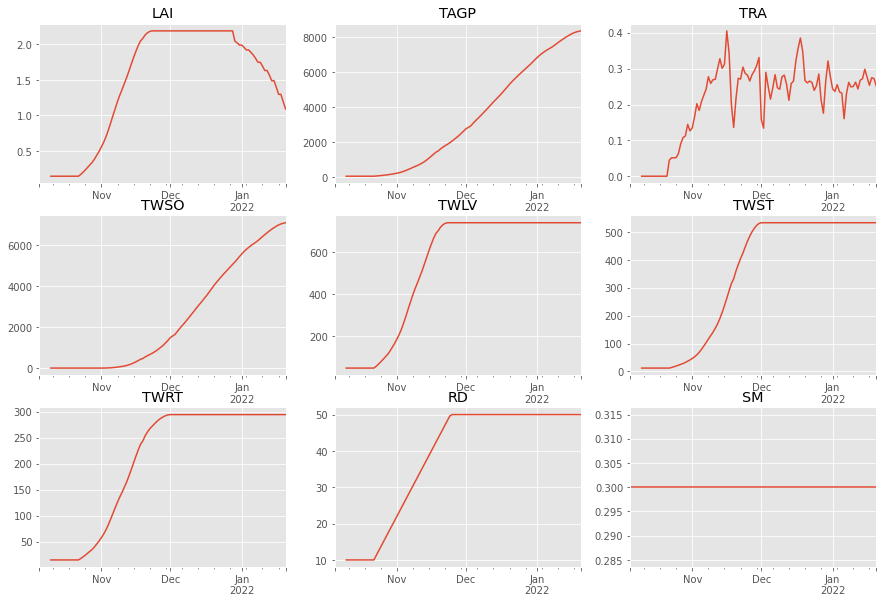

In [72]:
# Define a plotting size and subplot position
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,10))
# Iterate through the columns
for n, col in enumerate(['LAI', 'TAGP', 'TRA', 'TWSO', 'TWLV', 'TWST', 'TWRT', 'RD', 'SM']):
    # create 9 subplots (3 * 3), and start plotting from position 1 (n + 1; n starts 0) 
    ax = plt.subplot(3, 3, n + 1)
    # plotting the col to each subplot
    PP_results[[col]].plot(ax=ax)
    ax.set_title(col.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")
# help(plt.subplot)

## Try the other four cultivars available in the potato paremeters 

In [73]:
# NO IRRIGATION AGRONOMANAGEMNT 
import yaml
yaml_agro = """
- 2021-10-05:
    CropCalendar:
        crop_name: potato
        variety_name: {cultivar}
        crop_start_date: 2021-10-10
        crop_start_type: sowing
        crop_end_date: 2022-01-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null       
    StateEvents: null
"""
# Create a empty list object to store data 
results = []
# Define a cultivar name list 
cultivars = ["Potato_70" + str(i) for i in list(range(1, 5))]
# Iterate through the four cultivar names 
for i in cultivars:
    print(i)
    # update agromanagement with new start date and load it with yaml.load
    tmp = yaml_agro.format(cultivar=i)
    agromanagement = yaml.safe_load(tmp)
    # run wofost and collect output
    wofost = Wofost72_PP(parameters, wdp, agromanagement)
    wofost.run_till_terminate()
    output = wofost.get_output()
    df = pd.DataFrame(output).set_index("day")
    # append each potential yield simulation results for each cultivar
    results.append(df)

Potato_701
Potato_702
Potato_703
Potato_704


In [74]:
# Examine the 2nd results
results[1]

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2021-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,None
2021-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,None
2021-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,None
2021-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,None
2021-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,None
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-16,1.879027,0.476813,6503.426992,5519.984862,556.856162,426.585967,226.565816,0.127787,50.0,0.3,None
2022-01-17,1.888122,0.476813,6508.575567,5525.133438,556.856162,426.585967,226.565816,0.122602,50.0,0.3,None
2022-01-18,1.898278,0.416976,6508.575567,5525.133438,556.856162,426.585967,226.565816,0.118659,50.0,0.3,None


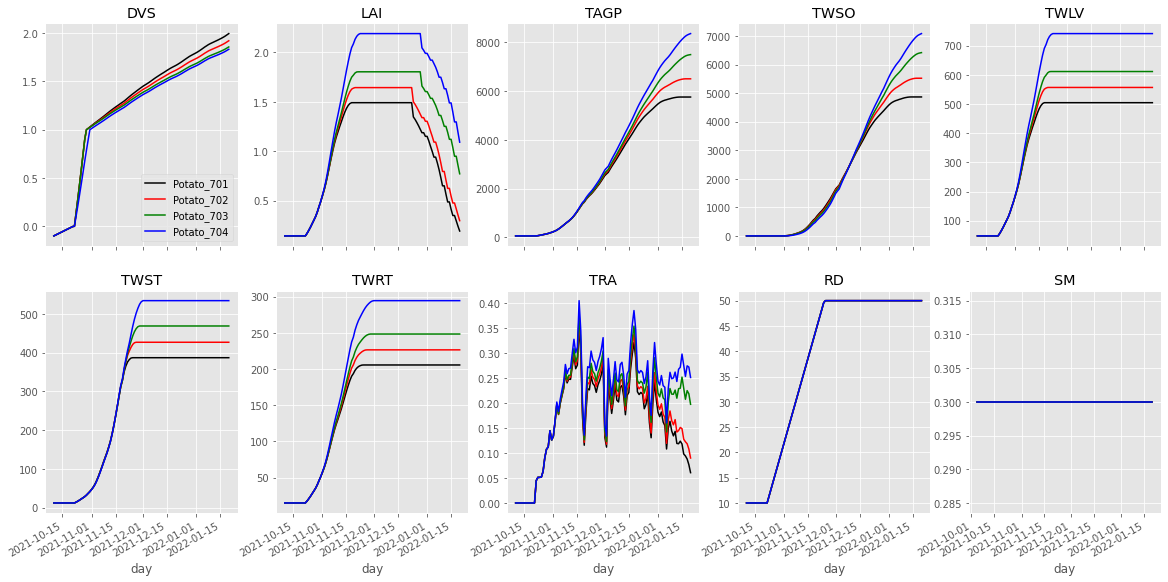

In [75]:
# Create a color palate for the 4 cultivars 
colors = ['k','r','g','b']
# Create two variables for plotting
# fig5 to define the size of the whole plotting area
# axes5 to define how many subplots(2*5)
fig5, axes5 = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
# Iterate through the colors, data and cultivar names 
for c, df, cultivar in zip(colors, results, cultivars):
    # For each combination of colors, data and cultivar names 
    # Draw the information on the subplot 
    for key, axis in zip(df.columns, axes5.flatten()):
        # plot the data on the subplot with labels 
        df[key].plot(ax=axis, title=key, color=c, label = cultivar)
        # plt.legend(loc="upper left")        
# Add a legend to the first subplot
axes5[0][0].legend()
# Modify the legend position 
fig.legend( loc='upper center')
# Modify the date format 
fig5.autofmt_xdate()

In [76]:
#compile my agronomic management 
Amount = pd.read_excel("../Data/Irrigation schedule CY22.xlsx", \
                        usecols='K:V')
# add dates for 90 days
Amount['Date'] = pd.date_range(start='10/05/2021', periods=90)
# change the date format 
Amount['Date'] = Amount.Date.dt.strftime("%Y-%m-%d")


In [77]:
# Subset the control irrigation treatment to try if the model would run
control = Amount.loc[Amount['Control'] != 0, ['Date','Control']]

In [78]:
# Create an empty list to store information 
dates = []
# Iterate through each row in the control dataframe 
for i in control.iterrows():
    # define a variable called application and assign the information about the amount of irrigation to put
    application = "\n        - " + i[1][0] + ": {amount: " + str(i[1][1]/10) + "," + " efficiency: 0.7}"
    # append the information to the list 
    dates.append(application)
# Change the list to a character string so we can join it to the agronomic object yaml_agro
dates = ''.join(dates)


In [85]:
import yaml
# Add the irrigation events into the TimedEvents section 
yaml_agro = """
- 2021-10-05:
    CropCalendar:
        crop_name: potato
        variety_name: Potato_701
        crop_start_date: 2021-10-10
        crop_start_type: sowing
        crop_end_date: 2022-01-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    -   event_signal: irrigate
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:        """ + \
        dates +\
        """
    StateEvents: null
"""
agromanagement = yaml.safe_load(yaml_agro)


In [86]:
wofost = Wofost72_WLP_FD(parameters, wdp, agromanagement)
wofost.run_till_terminate()

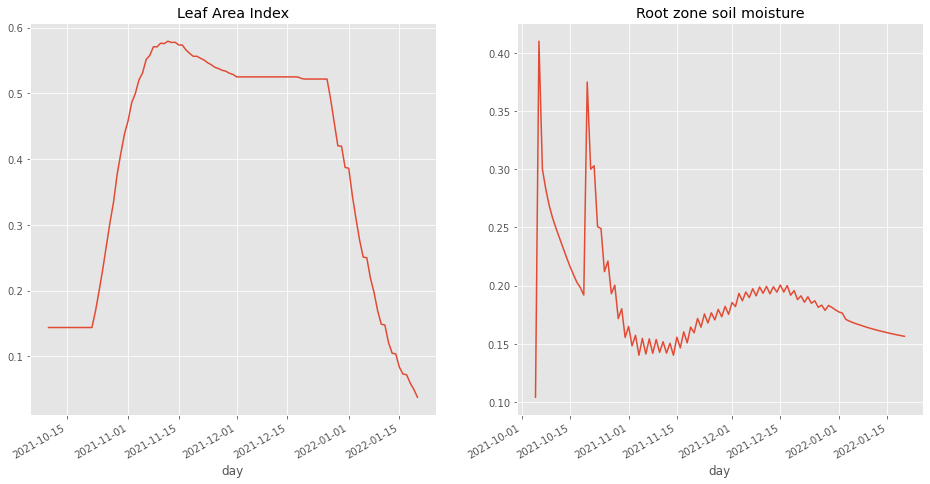

In [87]:
df_results = pd.DataFrame(wofost.get_output()).set_index("day")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
df_results['LAI'].plot(ax=axes[0], title="Leaf Area Index")
df_results['SM'].plot(ax=axes[1], title="Root zone soil moisture")
fig.autofmt_xdate()

Showing the differences in irrigation events
============================================

We combine the `SM`  column from the different data frames in a new dataframe and plot the results to see the effect of the differences in agromanagement.

## The main loop for making several WOFOST runs

In [105]:
# Show the column names of the irrigation data
Amount.columns
# Store the column names to a list 
treatments = ['Control', 'Control_75%', 'Control_50%', 'Early drought_75%',
              'Late drought_75%', 'Early drought 50%', 'Late drought 50%',
              'Middle drought_75%', 'Middle drought_50%', 'Early_Middle_75%',
              'Early_Middle_50%']
# Create a list to store information
results = []
# Iterate through the column names 
for col in treatments:
    # Subset the column from the Amount dataframe
    df = Amount.loc[Amount[col] != 0, ['Date', col]]
    # print(df) # just checking 
    print("Processing " + col)
    # Create a list to store irrigation dates and amount 
    dates = []
    # Iterate through the subset data and put the irrigation information to the list 
    for i in df.iterrows():
        application = "\n            - " + i[1][0] + ": {amount: " + str(i[1][1]/10) + "," + " efficiency: 0.7}"
        dates.append(application)
    # Convert the list to a character string     
    dates = ''.join(dates)
    # print(dates) # checking 
    print("Assembing the irrigation events for " + col)
    # Add irrigation information to the agronomic management 
    yaml_agro = """
    - 2021-10-05:
        CropCalendar:
            crop_name: potato
            variety_name: Potato_701
            crop_start_date: 2021-10-10
            crop_start_type: emergence
            crop_end_date: 2022-01-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents:
        -   event_signal: irrigate
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:             """ + dates +\
        """
        StateEvents: null
        """
    # Load the agromanagement     
    agromanagement = yaml.safe_load(yaml_agro)
    # agrolist.append(agromanagement)
    print("Simulating " + col)
    # Run a potential model 
    wofost = Wofost72_WLP_FD(parameters, wdp, agromanagement)
    wofost.run_till_terminate()
    # Retrieve the simulation results 
    sim_res = pd.DataFrame(wofost.get_output())
    # Change the day column to datetime
    sim_res.day = pd.to_datetime(sim_res.day)
    # Add a new column to record the treatment name 
    sim_res['Treatment'] = col
    # Append the datafrom to list 
    results.append(sim_res)


Processing Control
Assembing the irrigation events for Control
Simulating Control
Processing Control_75%
Assembing the irrigation events for Control_75%
Simulating Control_75%
Processing Control_50%
Assembing the irrigation events for Control_50%
Simulating Control_50%
Processing Early drought_75%
Assembing the irrigation events for Early drought_75%
Simulating Early drought_75%
Processing Late drought_75%
Assembing the irrigation events for Late drought_75%
Simulating Late drought_75%
Processing Early drought 50%
Assembing the irrigation events for Early drought 50%
Simulating Early drought 50%
Processing Late drought 50%
Assembing the irrigation events for Late drought 50%
Simulating Late drought 50%
Processing Middle drought_75%
Assembing the irrigation events for Middle drought_75%
Simulating Middle drought_75%
Processing Middle drought_50%
Assembing the irrigation events for Middle drought_50%
Simulating Middle drought_50%
Processing Early_Middle_75%
Assembing the irrigation event

In [106]:
# Convert the list that has all simulation results to a big dataframe 
df_results = pd.concat(results)
# Subset only four columns 
df_lai_sm = df_results.loc[:,['day','Treatment','LAI', 'SM']]
# .melt(id_vars=['day', 'Treatment'])
# Verify the dataframe 
df_results

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,Treatment
0,2021-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104000,6.240000,Control
1,2021-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.410000,9.300000,Control
2,2021-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,8.867657,Control
3,2021-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282649,8.694147,Control
4,2021-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268471,8.552365,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2022-01-16,2.0,0.0,371.372173,214.032141,116.119249,41.220783,38.238091,0.0,48.4,0.133299,7.812948,Early_Middle_50%
104,2022-01-17,2.0,0.0,371.372173,214.032141,116.119249,41.220783,38.238091,0.0,48.4,0.132908,7.794038,Early_Middle_50%
105,2022-01-18,2.0,0.0,371.372173,214.032141,116.119249,41.220783,38.238091,0.0,48.4,0.132545,7.776477,Early_Middle_50%
106,2022-01-19,2.0,0.0,371.372173,214.032141,116.119249,41.220783,38.238091,0.0,48.4,0.132162,7.757947,Early_Middle_50%


c:\Users\cflfcl\.conda\envs\py3_pcse\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 5 rows containing missing values.


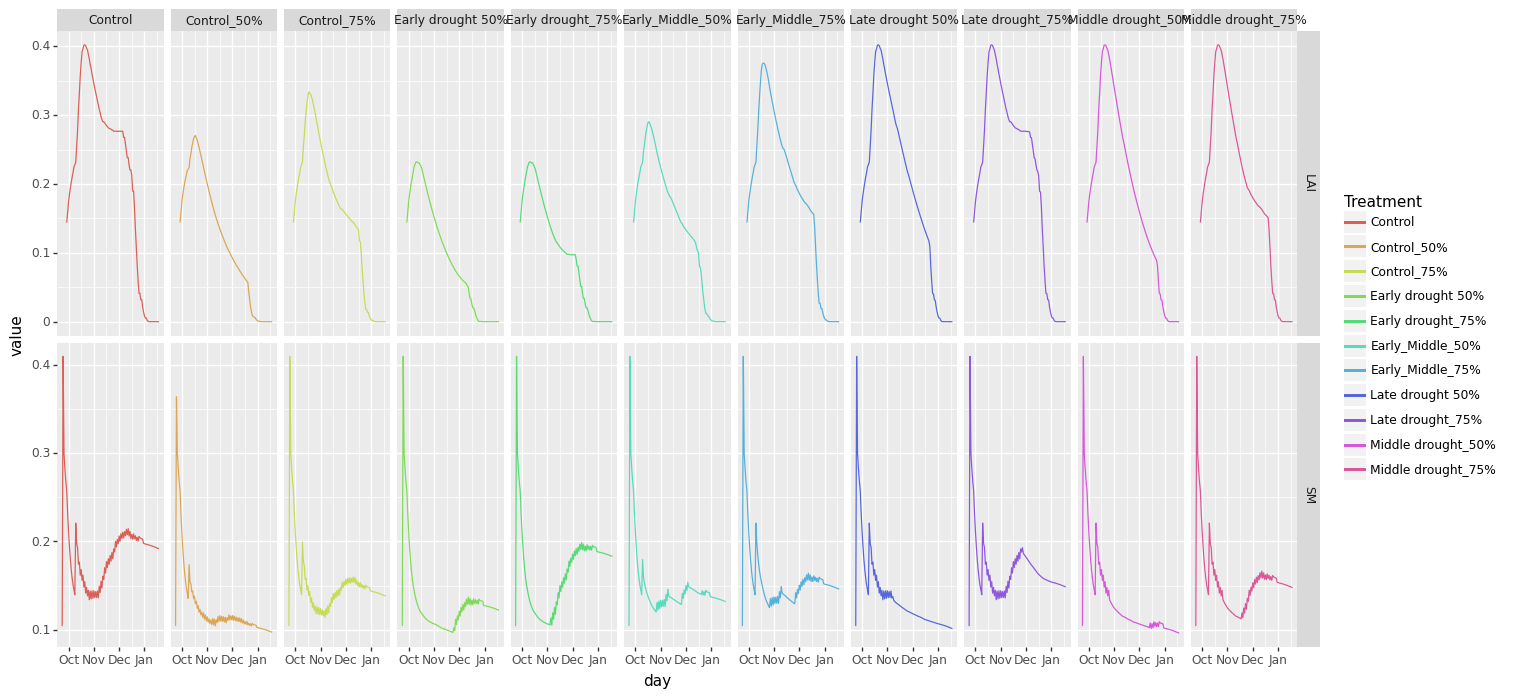

<ggplot: (179661807839)>

In [107]:
# Load date formatting functions from mizani package 
from mizani.breaks import date_breaks
from mizani.formatters import date_format
# Change the wide dataframe to a long format 
df_lai_sm_long = df_lai_sm.melt(id_vars=['day', 'Treatment'])
# ggplot(df_lai_sm, aes(x = 'day', y = 'SM', color = 'Treatment')) +\
#     geom_line() + \
#     facet_wrap('Treatment', scales= 'free_y',ncol = 2) + \
#     scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%m-%d')) + \
#     theme(figure_size=(16, 10))
# Use R visualisation syntax to visualise the results for LAI (leaf area index) and SM(root zone soil moisture content)
ggplot(df_lai_sm_long, aes(x = 'day', y = 'value', color = 'Treatment')) +\
    geom_line() + \
    facet_grid('variable ~ Treatment', scales= 'free_y') + \
    scale_x_datetime(breaks=date_breaks('4 weeks'), labels=date_format('%b')) + \
    theme(figure_size=(16, 8))

In [91]:
df_lai_sm

,day,Treatment,LAI,SM
0,2021-10-05,Control,NaN,0.3
1,2021-10-06,Control,NaN,0.3
2,2021-10-07,Control,NaN,0.3
3,2021-10-08,Control,NaN,0.3
4,2021-10-09,Control,NaN,0.3
...,...,...,...,...
103,2022-01-16,Early_Middle_50%,0.0,0.3
104,2022-01-17,Early_Middle_50%,0.0,0.3
105,2022-01-18,Early_Middle_50%,0.0,0.3
106,2022-01-19,Early_Middle_50%,0.0,0.3


# The timing treatment 


In [98]:
#compile my agro
Timing = pd.read_excel("../Data/Irrigation schedule CY22.xlsx", sheet_name="TIMING",
                        usecols='A:H')
# add dates 
Timing['Date'] = pd.date_range(start='10/05/2021', periods=90)
Timing['Date'] = Timing.Date.dt.strftime("%Y-%m-%d")


In [99]:
Timing.columns

Index(['Days', 'Control', 'Control_75%', 'Control_50%', 'Full_Every_2nd_week',
       'Full_Every_3rd_week', '75%_Every_2nd_week', '75%_Every_3rd_week',
       'Date'],
      dtype='object')

In [103]:
treatments = ['Control', 'Control_75%', 'Control_50%', 'Full_Every_2nd_week',
              'Full_Every_3rd_week', '75%_Every_2nd_week', '75%_Every_3rd_week']
results = []
for col in treatments:
    df = Timing.loc[Timing[col] != 0, ['Date', col]]
    # print(df) # just checking 
    print("Processing " + col)
    dates = []
    for i in df.iterrows():
        application = "\n            - " + i[1][0] + ": {amount: " + str(i[1][1]/10) + "," + " efficiency: 0.7}"
        dates.append(application)
    dates = ''.join(dates)
    # print(dates) # checking 
    print("Assembing the irrigation events for " + col)
    yaml_agro = """
    - 2021-10-05:
        CropCalendar:
            crop_name: potato
            variety_name: Potato_701
            crop_start_date: 2021-10-10
            crop_start_type: emergence
            crop_end_date: 2022-01-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents:
        -   event_signal: irrigate
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:             """ + dates +\
        """
        StateEvents: null
        """
    agromanagement = yaml.safe_load(yaml_agro)
    # agrolist.append(agromanagement)
    print("Simulating " + col)
    wofost = Wofost72_WLP_FD(parameters, wdp, agromanagement)
    wofost.run_till_terminate()
    sim_res = pd.DataFrame(wofost.get_output())
    sim_res.day = pd.to_datetime(sim_res.day)
    sim_res['Treatment'] = col

    results.append(sim_res)


Processing Control
Assembing the irrigation events for Control
Simulating Control
Processing Control_75%
Assembing the irrigation events for Control_75%
Simulating Control_75%
Processing Control_50%
Assembing the irrigation events for Control_50%
Simulating Control_50%
Processing Full_Every_2nd_week
Assembing the irrigation events for Full_Every_2nd_week
Simulating Full_Every_2nd_week
Processing Full_Every_3rd_week
Assembing the irrigation events for Full_Every_3rd_week
Simulating Full_Every_3rd_week
Processing 75%_Every_2nd_week
Assembing the irrigation events for 75%_Every_2nd_week
Simulating 75%_Every_2nd_week
Processing 75%_Every_3rd_week
Assembing the irrigation events for 75%_Every_3rd_week
Simulating 75%_Every_3rd_week


c:\Users\cflfcl\.conda\envs\py3_pcse\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 5 rows containing missing values.


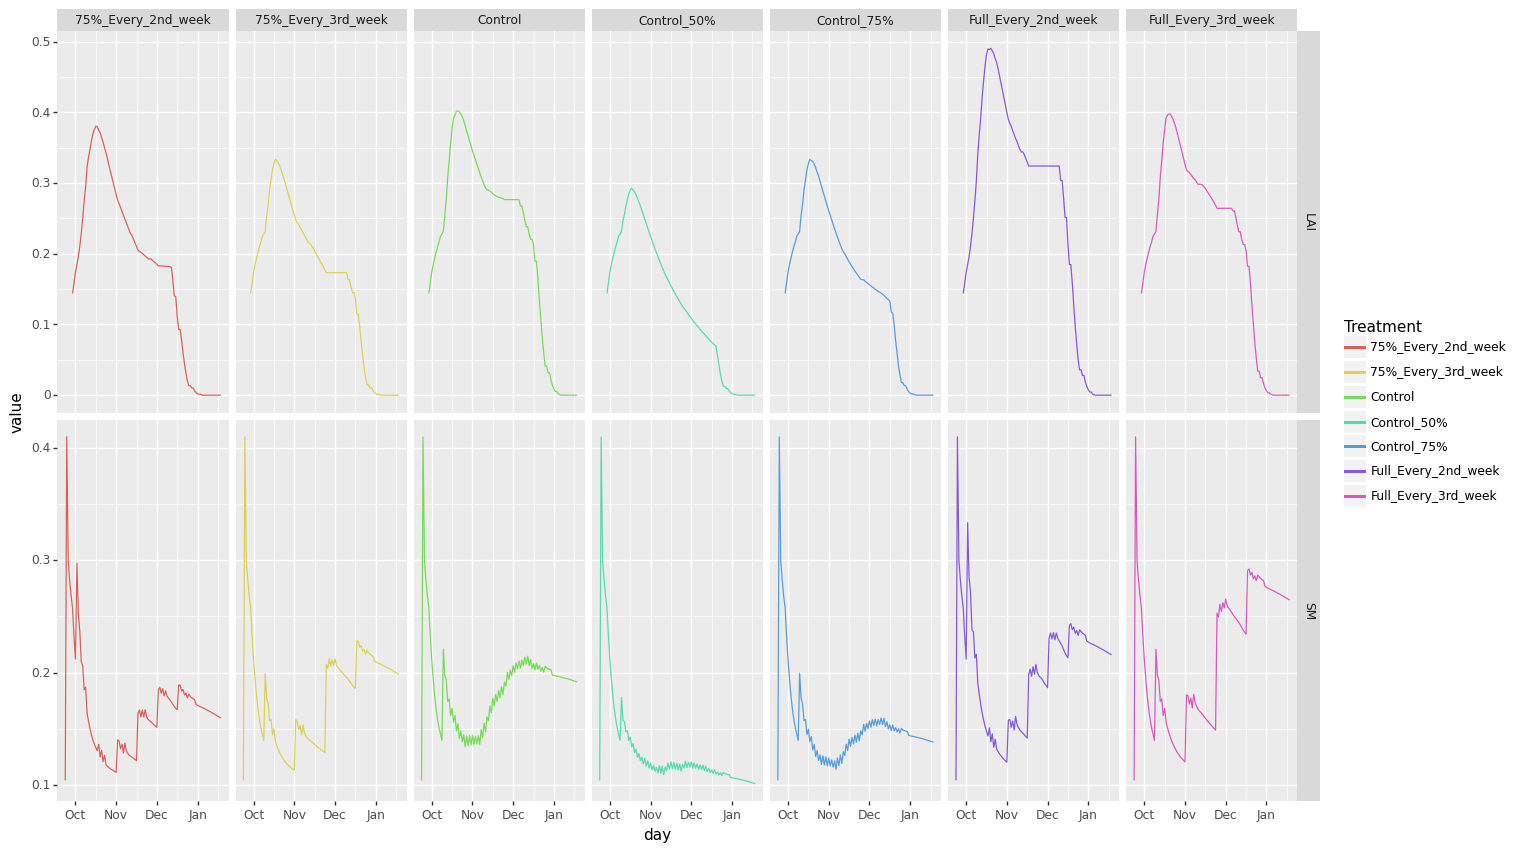

<ggplot: (179661671843)>

In [104]:
df_results = pd.concat(results)
df_lai_sm = df_results.loc[:,['day','Treatment','LAI','SM']]
df_lai_sm_long = df_lai_sm.melt(id_vars=['day', 'Treatment'])
ggplot(df_lai_sm, aes(x = 'day', y = 'SM', color = 'Treatment')) +\
    geom_line() + \
    facet_wrap('Treatment', scales= 'free_y',ncol = 2) + \
    scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%m-%d')) + \
    theme(figure_size=(16, 10))

ggplot(df_lai_sm_long, aes(x = 'day', y = 'value', color = 'Treatment')) +\
    geom_line() + \
    facet_grid('variable ~ Treatment', scales= 'free_y') + \
    scale_x_datetime(breaks=date_breaks('4 weeks'), labels=date_format('%b')) + \
    theme(figure_size=(16, 10))